## Optimize Portfolio

### Import libraries

In [1]:
import pandas as pd
import numpy as np
import scipy.optimize as spo
from utils.util import get_data, plot_data

### Initialization

In [2]:
start_date = '2010-01-01'
end_date = '2010-12-31'

# Define stocks in the portfolio
symbols = ['GOOG', 'AAPL', 'GLD', 'XOM'] 

dates = pd.date_range(start_date, end_date)

# Initialize allocations (equidistributed stocks)
#allocs = [1./len(symbols)] * 4

### Load and plot stock data

In [3]:
prices_all = get_data(symbols, dates)
prices = prices_all[symbols]  # only portfolio symbols
prices_SPY = prices_all['SPY']  # only SPY, for comparison later

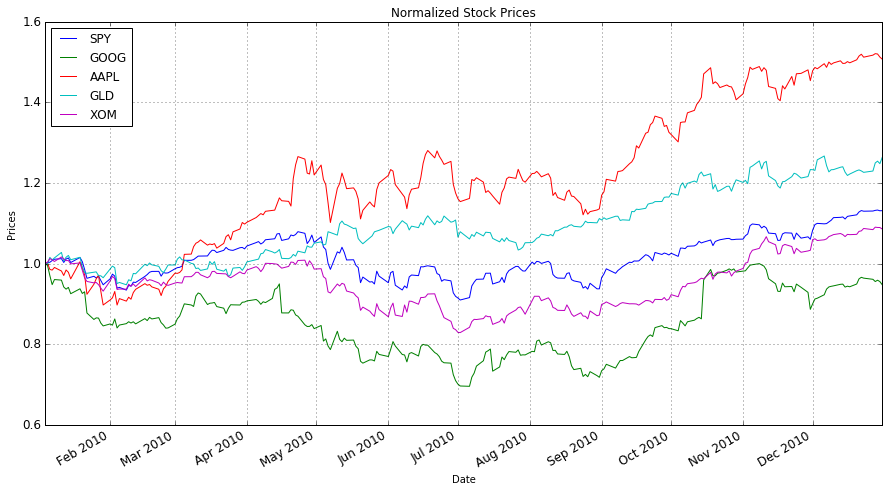

In [4]:
plot_data(prices_all/prices_all.ix[0], title="Normalized Stock Prices")

### Optimize portfolio allocations

In [5]:
def get_portfolio_value(prices, allocs, start_val=1):
    """Computes the daily portfolio value given daily prices for each stock in portfolio, 
    initial allocations(as fractions that sum to 1) and total starting value invested in portfolio"""
    # normalize all stock prices
    df = prices / prices.ix[0]
    # multiply prices by allocations of each equity
    df = df * allocs
    # multiply allocated values by initial investment value
    df = df * start_val
    # compute entire portfolio value on each day
    port_val = df.sum(axis=1)
    return port_val

In [6]:
def get_portfolio_stats(port_val, daily_rf=0, samples_per_year=252):
    """Calculates the cumulative return, average daily return (and standard deviation) and Sharpe ratio of a portfolio
    given the daily portfolio values, the daily risk-free rate of return, and the frequency of sampling 
    (or, how many trading days there are)"""
    # Compute cumulative ruturn (from beginning to end)
    cum_ret = (port_val[-1] / port_val[0]) - 1
    # Compute daily returns
    daily_returns = port_val.copy()
    daily_returns = (daily_returns/daily_returns.shift(1))-1
    daily_returns.ix[0,0] = 0
    # Compute daily return mean and standard deviation (note: std_daily_ret = volatility)
    avg_daily_ret = daily_returns.mean()
    std_daily_ret = daily_returns.std()
    # calculate sharp ratio
    daily_rf = 0 
    samples_per_year = 252
    sharpe_ratio = ((daily_returns - daily_rf).mean()/daily_returns.std()) * np.sqrt(samples_per_year)
    return cum_ret, avg_daily_ret, std_daily_ret, sharpe_ratio

In [7]:
def error_optimal_allocations(allocs, prices):
    """A helper function for the find_optimal_allocations function to minimize over"""
    port_val = get_portfolio_value(prices, allocs, 1)
    cum_ret, avg_daily_ret, std_daily_ret, sharpe_ratio = get_portfolio_stats(port_val)
    error = sharpe_ratio * -1
    return error

In [8]:
def find_optimal_allocations(prices):
    """Find optimal allocations for a stock portfolio, optimizing for Sharpe ratio, 
    given the daily prices for each stock in the portfolio"""
    guess = 1.0/prices.shape[1]
    function_guess = [guess] * prices.shape[1]
    bnds = [[0,1] for _ in prices.columns]
    cons = ({ 'type': 'eq', 'fun': lambda function_guess: 1.0 - np.sum(function_guess) })
    result = spo.minimize(error_optimal_allocations, function_guess, args = (prices,), method='SLSQP', bounds = bnds, 
                          constraints = cons, options={'disp':True})
    allocs = result.x
    return allocs

In [9]:
# Get optimal allocations
allocs = find_optimal_allocations(prices)
allocs = allocs / np.sum(allocs)  # normalize allocations, if they don't sum to 1.0

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -1.99998721601
            Iterations: 6
            Function evaluations: 36
            Gradient evaluations: 6


In [10]:
# Get daily portfolio value 
port_val = get_portfolio_value(prices, allocs)

# Get portfolio statistics
cum_ret, avg_daily_ret, std_daily_ret, sharpe_ratio = get_portfolio_stats(port_val)

# Print statistics
print "Start Date:", start_date
print "End Date:", end_date
print "Symbols:", symbols
print "Optimal allocations:", allocs
print "Sharpe Ratio:", sharpe_ratio
print "Volatility (stdev of daily returns):", std_daily_ret
print "Average Daily Return:", avg_daily_ret
print "Cumulative Return:", cum_ret

Start Date: 2010-01-01
End Date: 2010-12-31
Symbols: ['GOOG', 'AAPL', 'GLD', 'XOM']
Optimal allocations: [  6.18922290e-16   3.96662800e-01   6.03337200e-01   0.00000000e+00]
Sharpe Ratio: 1.99998721601
Volatility (stdev of daily returns): 0.0100965377917
Average Daily Return: 0.00127203606432
Cumulative Return: 0.36009108084


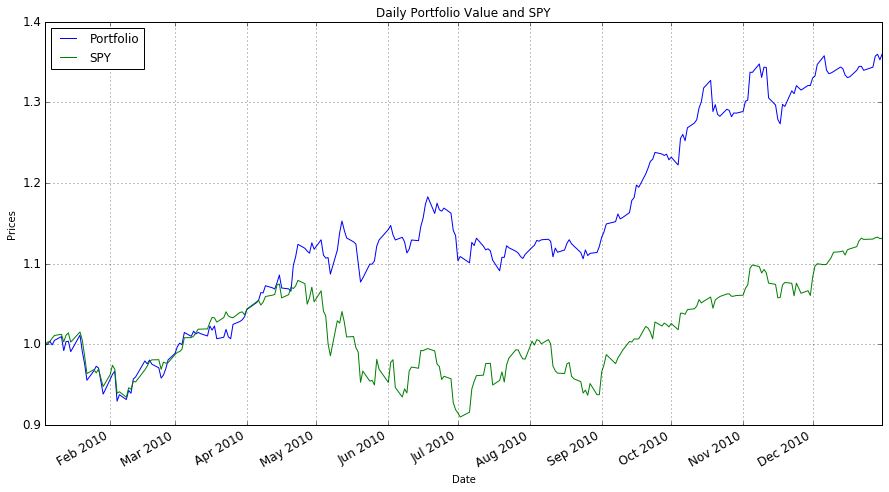

In [11]:
# Compare daily portfolio value with normalized SPY
normed_SPY = prices_SPY / prices_SPY.ix[0, :]
df_temp = pd.concat([port_val, normed_SPY], keys=['Portfolio', 'SPY'], axis=1)
plot_data(df_temp, title="Daily Portfolio Value and SPY")

In [12]:
# Print the final portfolio composition
for k in range(len(symbols)):
    print symbols[k], ":", "{0:.2f}".format(allocs[k]), "%"
print "\nTot :", np.sum(allocs)*100, "%"

GOOG : 0.00 %
AAPL : 0.40 %
GLD : 0.60 %
XOM : 0.00 %

Tot : 100.0 %
